<a href="https://colab.research.google.com/github/Enri98/pageRank-prado/blob/main/pageRank_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 3: Link analysis on Prado Dataset**
In this project, two variations of the PageRank algorithm, unweighted and weighted edges, were applied to a dataset of paintings from the Prado Museum. The goal was to rank the paintings based on their relationships, where connections were defined by shared tags between artworks. Each painting was considered as a node in a graph, and edges between these were formed based on the shared tags. The unweighted PageRank algorithm treated all connections equally, while the weighted PageRank variation assigned more importance to links with more common tags, providing a nuanced ranking system.

The implementation utilized PySpark’s distributed computing capabilities to efficiently handle the large dataset and create scalable solutions.

The results showed that both algorithms ranked the same painting “Retrato mortuorio del periodista Pedro Avial Taracena” by José Nin y Tudó at the top, although the remaining rankings varied between the two approaches; interestingly, the weighted PageRank algorithm favored several paintings by Francisco de Goya.


## Upload dataset

Install pyspark and import libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=254d39117c0683cae882a4f10fc44752db3db420b224441b8128b074210e6cc6
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from collections import Counter

from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"
!kaggle datasets download -d maparla/prado-museum-pictures

Dataset URL: https://www.kaggle.com/datasets/maparla/prado-museum-pictures
License(s): MIT
100% 24.9G/24.9G [04:44<00:00, 139MB/s]
100% 24.9G/24.9G [04:44<00:00, 94.1MB/s]


In [4]:
!unzip prado-museum-pictures.zip -x "*.jpg" # don't unzip the jpg pictures

Archive:  prado-museum-pictures.zip
  inflating: prado.csv               


In [5]:
prado_path = 'prado.csv'

## Peek at the data

In [6]:
df_pl = pl.read_csv(prado_path)

In [7]:
df_pl.describe()

describe,work_url,work_image_url,author,author_bio,author_url,author_id,work_title,work_subtitle,work_exposed,work_description,work_tags,technical_sheet_numero_de_catalogo,technical_sheet_autor,technical_sheet_titulo,technical_sheet_fecha,technical_sheet_tecnica,technical_sheet_soporte,technical_sheet_dimension,technical_sheet_serie,technical_sheet_procedencia,bibliography,inventory,expositions,ubication,technical_sheet_autores,technical_sheet_edicion_/_estado,technical_sheet_materia,technical_sheet_ceca,technical_sheet_autora,technical_sheet_lugar_de_produccion
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""count""","""13487""","""13487""","""13487""","""9405""","""12360""","""12360""","""13487""","""13487""","""13487""","""13487""","""13487""","""13487""","""13408""","""13487""","""13485""","""13390""","""11035""","""13464""","""3790""","""13428""","""13479""","""13168""","""10889""","""6539""","""0""","""423""","""2441""","""910""","""79""","""334"""
"""null_count""","""0""","""0""","""0""","""4082""","""1127""","""1127""","""0""","""0""","""0""","""0""","""0""","""0""","""79""","""0""","""2""","""97""","""2452""","""23""","""9697""","""59""","""8""","""319""","""2598""","""6948""","""13487""","""13064""","""11046""","""12577""","""13408""","""13153"""
"""mean""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""min""","""https://www.mu…","""https://conten…","""Abadía el Viej…","""(Spain), 1483,…","""https://www.mu…","""003a654b-ee5f-…","""""Hispania"". Bu…",""".""","""Depósito en ot…","""""A moro muerto…","""''L’Artiste, J…","""D000002""","""Abadía el Viej…","""''Crepúsculo''…","""10 - 50""","""Acuarela""","""Cartulina""","""Alto (de luz):…","""''L’Artiste, J…","""A. C. von Fre…","""""122"" manuscri…","""""112"" manuscri…","""""1"" Manuscrito…","""""1"" (repasado)…",null,"""1898""","""Aguamarina; Am…","""Abariltur (no …","""Aggerholm, Eva…","""Alcora (Castel…"
"""25%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""max""","""https://www.mu…","""https://conten…","""Österman, Bern…","""Íscar, Vallado…","""https://www.mu…","""ffeab1ca-6f5d-…","""Últimos moment…","""Último tercio …","""Ábside""","""“Modellino” cu…","""“Sacra Familia…","""P008391""","""Österman, Bern…","""Últimos moment…","""Último tercio …","""Óleo; Témpera""","""Vitela""","""Peso: 26,8 Kg;…","""“Sacra Familia…","""Émile Galichon…","""“Noticias [Jua…","""† MI GO PEDRET…","""⚜ Flor de lis,…","""Úbeda - Ayunta…",null,"""Tercer estado …","""Ágata; Oro; Ru…","""Valentia (Vale…","""Ykens, Cathari…","""Vietnam"""


#### Spark session

In [8]:
# fire up the Spark session and upload df
spark = SparkSession.builder.appName('prado').getOrCreate()
df = spark.read.csv(prado_path, header=True, multiLine=True, escape='"')

In [9]:
df.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+----------------------------------+---------------------+----------------------+---------------------+-----------------------+-----------------------+-------------------------+---------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+--------------------------------+-----------------------+--------------------+----------------------+-----------------------------------+
|            work_url|      work_image_url|              author|          author_bio|          author_url|           author_id|          work_title|       work_subtitle|work_exposed|    work_description|           work_tags|technical_sheet_numero_de_catalogo|technical_sheet_autor|technical_sheet_titulo|

In [10]:
print(f'Dataset has {df.count()} rows')

Dataset has 13487 rows


## Data pre-processing

#### Split work_tags

We are connecting the paintings based on the shared tags, in the column "work_tags". It is currently a string so we need to convert it to an array.

In [11]:
# string is separeted by semicolon
print(df.select('work_tags').collect()[0][0])

Serie de dibujos para el fresco la Caída de los Gigantes en el Palacio Real de Madrid;Lápiz negro;Papel verdoso;Estudio de cabeza;Mitología;1764;+


In [12]:
# split the tags string into a list of tags
df = df.withColumn('tags_array', split(col('work_tags'), ';'))

In [13]:
df.select('tags_array').collect()[0][0] # check first row's tags array

['Serie de dibujos para el fresco la Caída de los Gigantes en el Palacio Real de Madrid',
 'Lápiz negro',
 'Papel verdoso',
 'Estudio de cabeza',
 'Mitología',
 '1764',
 '+']

#### Tags distribution

In [14]:
# list with all tags array
tags_lists = df.select(collect_list("tags_array")).first()[0]

all_tags = [tag for sublist in tags_lists for tag in sublist]

tags_counter = Counter(all_tags)

print(f'Number of unique tags: {len(set(all_tags))} \n')

print('Most common tags:')
for tag, count in tags_counter.most_common(20):
  print(f'{tag}: {count}')

Number of unique tags: 3548 

Most common tags:
+: 12993
Óleo: 4177
Lienzo: 3225
Pluma: 1923
Papel verjurado: 1477
Lápiz negro: 1248
Acuñación: 1120
Bronce: 987
Papel avitelado: 954
Tinta parda: 944
Santos: 937
Aguada: 916
Sanguina: 836
Animales: 813
Figura Humana: 811
Clarión: 768
Retrato real: 734
Aguada parda: 725
Tabla: 669
Caballo (Equus ferus caballus): 656


#### Drop + tag

The "+" tags is the most frequent.

Checking on the Prado museum website, we can see that "+" is not a real label/tag, rather it's a button to display more tags. Hence, it's not meaningful and connects most of the paintings for no reason.

For these reasons, we decided to **drop the "+" tag** in the following analysis.

In [15]:
# drop the + tag
df = df.withColumn('tags_array', array_remove(col('tags_array'), "+"))
# rerun since + was dropped
tags_lists = df.select(collect_list("tags_array")).first()[0]
all_tags = [tag for sublist in tags_lists for tag in sublist]
print(f'Number of unique tags (whitout +): {len(set(all_tags))} \n')

Number of unique tags (whitout +): 3547 



In [16]:
tags_counter = Counter(all_tags)
# make a sorted dict of the tags frequency
tags_counted = dict(sorted(tags_counter.items(), key=lambda x: x[1], reverse=True))
print(f'Average Tag frequency: {np.mean(list(tags_counted.values()))}')

Average Tag frequency: 22.86467437270933


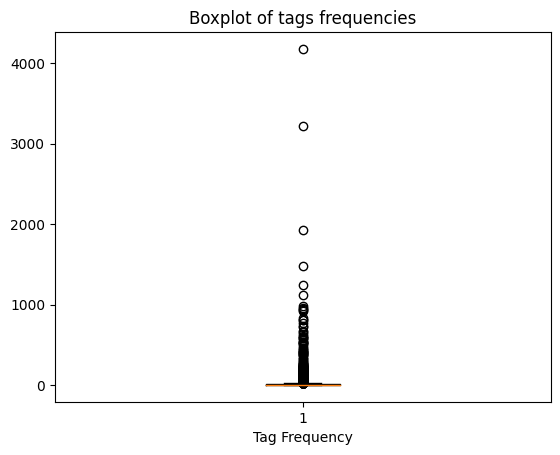

In [17]:
plt.boxplot(list(tags_counted.values()))
plt.title('Boxplot of tags frequencies')
plt.xlabel('Tag Frequency')
plt.show()


## Graph

#### Sample dataframe (optional)
If any of our readers is interested, it is possible to use only a sample of the dataframe and create a smaller network, simply by commenting and uncommeting the lines in the next code chunk.

In [18]:
# df_sample = df.sample(fraction=0.1, seed=69)
# df_id = df_sample.withColumn('id', monotonically_increasing_id())

# we create a new node id as increasing integers
df_id = df.withColumn('id', monotonically_increasing_id())

### Create edge df
In the next code chunk we create the edge RDD:

*   we explode the dataframe so we have a tag for each row
*   group the paintings ids by each tag
*   each combination of painting in a tag group represents 2 nodes that are connected
*   since the graph is undirected by nature, we represent that with 2 directed edges, of opposite directions, for each connected pair of nodes
*   drop the duplicate rows formed by pair of paintings that are in more than one tag group



In [19]:
# Expand the tags_array so each tag is in a separate row
tags_df = df_id.select(col("id"), col("work_url"), explode(col("tags_array")).alias("tag"))

# group by tag
tags_rdd = tags_df.rdd.map(lambda row: (row['tag'], row['id'])).repartition(200)
tag_groups_rdd = tags_rdd.groupByKey().mapValues(list)

# generate the edges (combinations of painting ids)
def generate_edges(paintings):
    edges = list(itertools.combinations(paintings, 2))
    # since we the graph is undirected, we add for each edge the other direction
    bidirectional_edges = [(edge[0], edge[1]) for edge in edges] + [(edge[1], edge[0]) for edge in edges]

    return bidirectional_edges

# we keep an RDD with duplicate rows for the weighted PageRank approach
edges_rdd_dupl = tag_groups_rdd.flatMap(lambda x: generate_edges(x[1]))

edges_rdd = edges_rdd_dupl.distinct()


In [20]:
print(f'Total number of edges: {edges_rdd.count()}')


Total number of edges: 36145728


### Nodes degrees distribution

In [21]:
# check the node degree distribution
degree_rdd = edges_rdd.flatMap(lambda edge: [(edge[0], 1), (edge[1], 1)])
node_degrees = degree_rdd.reduceByKey(lambda a, b: a + b) # count how many times each node appears

# map the degree to their frequencies
degree_distribution = node_degrees.map(lambda x: (x[1], 1)) \
                                  .reduceByKey(lambda a, b: a + b) \
                                  .sortByKey()
degree_distribution_list = degree_distribution.collect()


In [22]:
print("Nodes degrees:")
for d, c in degree_distribution_list[:5]:
    print(f"Low degree: {d}, frequency: {c}")
for d, c in degree_distribution_list[-5:]:
    print(f"High degree: {d}, frequency: {c}")


Nodes degrees:
Low degree: 22, frequency: 2
Low degree: 42, frequency: 2
Low degree: 114, frequency: 1
Low degree: 120, frequency: 2
Low degree: 126, frequency: 1
High degree: 12692, frequency: 1
High degree: 12730, frequency: 1
High degree: 12924, frequency: 1
High degree: 12982, frequency: 1
High degree: 13028, frequency: 1


Since both the in-degree and out-degree of the the least connected node are 13, we see there are **no deadend nodes**.

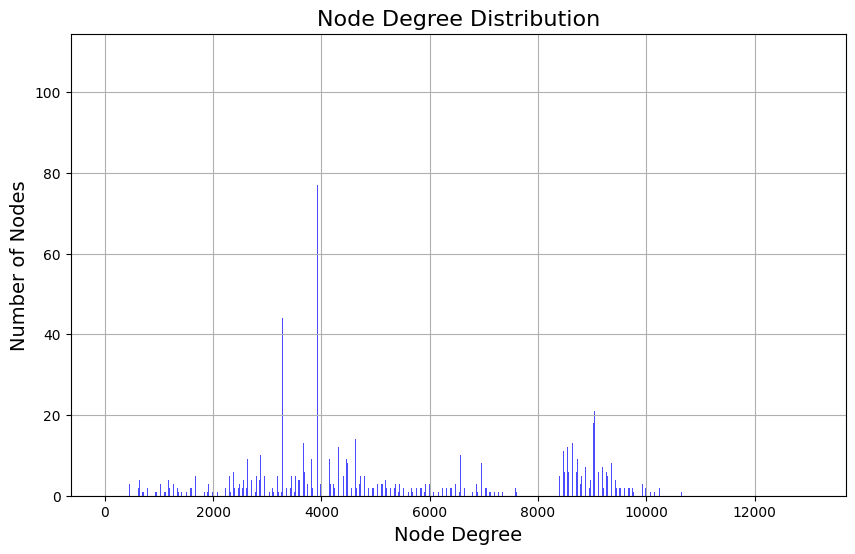

In [23]:
# plot degree distribution
plt.figure(figsize=(10, 6))
plt.bar([d for d,c in degree_distribution_list],
        [c for d,c in degree_distribution_list],
        color='blue', alpha=0.7)
plt.xlabel('Node Degree', fontsize=14)
plt.ylabel('Number of Nodes', fontsize=14)
plt.title('Node Degree Distribution', fontsize=16)
plt.grid(True)
plt.show()

## PageRank
At last, it's time to implement the function to compute the PageRank values.

Since the dataset is quite big, and the transition matrix is sparse, we decided to use another approach for representing the links and computing contributions: the **adjacency list**. This would make the computations less cumbersome.

Firstly, we defined a function to compute the euclidean distance (L1-norm or L2-norm), in order to see when the pageRank values would converge.

Our PageRank function is structured as follows:

*   Inputs:
  * the RDD with the edge information
  * the number of iterations for the PR values to be updated
  * the dampening factor meaning the possibility of jumping to a random node
  * the tolerance under which we consider the PR values to converge

*  first compute the adjacency list from the edge RDD
*   initialize the first pageRank as a uniform probability over all nodes

Inside the iterations loop:
* check if the the previous PR values converged
* compute the PR contribution of nodes to their neighbors from the adjacency list and previous iteration's PR
* compute the PR values of the current iteration, according to the formula:

$$
PR(V_i) = d \cdot \sum_{V_j \in in-neighbors(V_i)} \frac{PR(V_j)}{length(V_j)} + \frac{1 - d}{N}
$$

  * update the distance value between current PR and previous iteration's PR

Output the PageRank values for the nodes

In [24]:
# distance functions to check PR convergence
def euclidean_distance(new_pr, old_pr):
  distance = np.sqrt(new_pr.join(old_pr)\
                     .mapValues(lambda x: (x[0] - x[1])**2)\
                     .values().sum())
  return distance

def manhattan_distance(new_pr, old_pr):
  distance = new_pr.join(old_pr)\
                   .mapValues(lambda x: abs(x[0] - x[1])\
                   .values().sum())
  return distance

In [25]:
def pageranker(edges_rdd, iterations=50, d=0.85, tolerance=1e-6):
  print('Initializing variables...')
  # compute the adjency list from the edges
  adjacency_list = edges_rdd.groupByKey().mapValues(list)
  # adjacency_list = {v_j : [v_i, ...], ...}

  # initialize variables and first pageRank
  num_nodes = adjacency_list.count()
  page_ranks = adjacency_list.mapValues(lambda _: 1 / num_nodes)
  distance = tolerance + 1

  print('Starting iterations...')
  # loop
  for i in range(iterations):

    if distance < tolerance:
      print(f'Converged after {i} iterations')
      break

    old_page_ranks = page_ranks

    # PR contributions to node's neighbors
    contributions = page_ranks.join(adjacency_list).flatMap(
        lambda node_data: [(neighbor, node_data[1][0] / len(node_data[1][1]))
        for neighbor in node_data[1][1]])
    # output join = {v_j : (pr(v_j), [v_i, ...]), ...}
    # contributions = [( v_i, pr(v_j)/num_neighbors ), ...]

    # compute the new pageRanks
    page_ranks = contributions.reduceByKey(lambda a, b: a + b)\
                  .mapValues(lambda pr: d * pr + (1 - d)/num_nodes)

    # update distance between new and old PR
    distance = euclidean_distance(page_ranks, old_page_ranks)
    print(f'Iteration {i + 1} - distance: {distance}')

  print('PageRank computations completed!')
  return page_ranks.collect()


In [26]:
pr_values = pageranker(edges_rdd, iterations=50, d=0.85, tolerance=1e-6)

Initializing variables...
Starting iterations...
Iteration 1 - distance: 0.0018896620409191644
Iteration 2 - distance: 0.0005666358714482182
Iteration 3 - distance: 0.00031101408056006657
Iteration 4 - distance: 0.00019267618573441317
Iteration 5 - distance: 0.00012727080100220922
Iteration 6 - distance: 8.775658384226424e-05
Iteration 7 - distance: 6.225707673738938e-05
Iteration 8 - distance: 4.500302819502035e-05
Iteration 9 - distance: 3.293864671252279e-05
Iteration 10 - distance: 2.43130292524981e-05
Iteration 11 - distance: 1.805201979818218e-05
Iteration 12 - distance: 1.3459755141579463e-05
Iteration 13 - distance: 1.0066627205674536e-05
Iteration 14 - distance: 7.546193975381726e-06
Iteration 15 - distance: 5.666674776707029e-06
Iteration 16 - distance: 4.260977083822362e-06
Iteration 17 - distance: 3.207301271476761e-06
Iteration 18 - distance: 2.4161330213927457e-06
Iteration 19 - distance: 1.821279101911674e-06
Iteration 20 - distance: 1.373561244939412e-06
Iteration 21 - 

We define a function to map the pageranks to the original paintings

In [27]:
def map_pagerank_to_info(pagerank_values, df_id):

    # mapping from node id to (author, title, catalogue number)
    nodes_ids_mapping = dict(
        df_id.select('id', 'technical_sheet_numero_de_catalogo', 'author', 'work_title')\
             .rdd.map(lambda row: (row['id'], (row['author'], row['work_title'], row['technical_sheet_numero_de_catalogo'])))\
             .collect())

    # combine PR values with the painting information
    pagerank_info = [
        (node_id, pr_value, nodes_ids_mapping[node_id][0],
         nodes_ids_mapping[node_id][1], nodes_ids_mapping[node_id][2])
        for node_id, pr_value in pagerank_values]
    # output = [(id, PR, author, title, catalogue number), ...]

    # sort by pagerank
    pagerank_info_sorted = sorted(pagerank_info, key=lambda x: x[1], reverse=True)

    return pagerank_info_sorted


#### Results

In [28]:
print('Top PageRank paintings: \n')
for (id, pr, author, title, cat_num) in map_pagerank_to_info(pr_values, df_id)[:10]:
  print(f'{author}: "{title}" ---> PR: {pr}')

Top PageRank paintings: 

Nin y Tudó, José: "Retrato mortuorio del periodista Pedro Avial Taracena" ---> PR: 0.00015103882538922218
Anónimo: "San Joaquín, Santa Ana y la Virgen Niña" ---> PR: 0.00015027181924075854
Sánchez Perrier, Emilio: "Berlina tirada por un caballo en Sevilla" ---> PR: 0.0001494849935387582
Reynolds, Sir Joshua: "Retrato de James Bourdieu" ---> PR: 0.0001493752084443867
Anónimo (Obra copiada de: El Greco): "San Francisco en oración" ---> PR: 0.00014747987056730946
Creti, Donato  ?: "Estudio de guerrero romano" ---> PR: 0.0001442996777283197
Hernández Nájera, Miguel: "Víspera del Dos de Mayo" ---> PR: 0.0001411289362628883
Jover y Casanova, Francisco: "Tratado de Cambray" ---> PR: 0.00013979843307939627
Oliva y Rodrigo, Eugenio: "Cervantes, en sus últimos días, escribe la dedicatoria del Quijote al conde de Lemos" ---> PR: 0.00013889075855638916
Goya y Lucientes, Francisco de: "Cabeza de asno de perfil, relinchando" ---> PR: 0.00013832715943821813


## PageRank Weighted

In the following part, we decided to try a different approach: we computed edges based on the numbers of tags shared by 2 paintings.

First we add the weight column to the edge RDD, then we normalize the weight by dividing each weight $w_i$ by the sum of the out-links' weights coming from $w_i$'s node.

#### Create weighted edge RDD

In [29]:
# add the weight column using reduceByKey()
edges_rdd_weighted = edges_rdd_dupl.map(lambda edge: (edge, 1)) \
                              .reduceByKey(lambda a, b: a + b) \
                              .map(lambda x: (x[0][0], x[0][1], x[1]))  # (start, end, weight)

edges_rdd_weighted_norm = edges_rdd_weighted.map(
    lambda x: (x[0], (x[1], x[2]))).join(
        edges_rdd_weighted.map(     # inside the join there's (start, tot weight)
            lambda x: (x[0], x[2])).reduceByKey(
                lambda a, b: a + b)).map( # output join: (start, ((end, weight), tot weight))
                    lambda x: (x[0], x[1][0][0], x[1][0][1] / x[1][1]))
                # output: (start, end, norm weight)

In [30]:
edges_rdd_weighted_norm.take(3)

[(11200, 2902, 0.00013032712107389547),
 (11200, 13158, 0.00026065424214779094),
 (11200, 5830, 0.00026065424214779094)]

The new PageRank function is similar to the one of the previous section, the main differences are:

*   The input edge RDD also contains the weights
*   The computed adjacency list includes the respective weight next to each neighbor node
*   The contributions of PR to the neighboring nodes are computed by multiplying the PR value with the respective weight

The PR values are computed according with the formula:

$$
PR(V_i) = d \cdot \sum_{V_j \in in-neighbors(V_i)} {PR(V_j)}\cdot{w_ji} + \frac{1 - d}{N}
$$


In [31]:
def pageranker_weighted(edges_rdd_weighted_norm, iterations=50, d=0.85, tolerance=1e-6):
    print('Initializing variables...')

    # Create an adjacency list that includes weights
    adjacency_list = edges_rdd_weighted_norm.map(lambda x: (x[0], (x[1], x[2]))) \
                                            .groupByKey() \
                                            .mapValues(list)
    # adjacency_list = {v_j: [(v_i, weight_ji), ...], ...}

    # initialize variables and first PageRank values
    num_nodes = adjacency_list.count()
    page_ranks = adjacency_list.mapValues(lambda _: 1 / num_nodes)
    distance = tolerance + 1

    print('Starting iterations...')
    # loop and update the PR values
    for i in range(iterations):
        if distance < tolerance:
            print(f'Converged after {i} iterations')
            break

        old_page_ranks = page_ranks

        # calculate contributions based on the normalized weights
        contributions = page_ranks.join(adjacency_list).flatMap(
            lambda node_data: [
                (neighbor, node_data[1][0] * weight)  # pr(v_j) * weight_ji
                for neighbor, weight in node_data[1][1]
            ])
        # contributions = [(v_i, pr(v_j) * weight_ji), ...]

        # Aggregate contributions to get new PR
        page_ranks = contributions.reduceByKey(lambda a, b: a + b) \
                                  .mapValues(lambda pr: d * pr + (1 - d) / num_nodes)

        # update distance between new and old PageRanks (for convergence check)
        distance = euclidean_distance(page_ranks, old_page_ranks)
        print(f'Iteration {i + 1} - distance: {distance}')

    print('PageRank computations completed!')
    return page_ranks.collect()


In [32]:
pr_w_values = pageranker_weighted(edges_rdd_weighted_norm, iterations=50, d=0.85, tolerance=1e-6)

Initializing variables...
Starting iterations...
Iteration 1 - distance: 0.0019406418722611237
Iteration 2 - distance: 0.0005552498114770545
Iteration 3 - distance: 0.00029520408739376375
Iteration 4 - distance: 0.00018599060584001032
Iteration 5 - distance: 0.0001281296292299868
Iteration 6 - distance: 9.305857698295508e-05
Iteration 7 - distance: 6.968906012393878e-05
Iteration 8 - distance: 5.3092862455789585e-05
Iteration 9 - distance: 4.083548250877893e-05
Iteration 10 - distance: 3.1574846811768845e-05
Iteration 11 - distance: 2.448854372495648e-05
Iteration 12 - distance: 1.902717816564598e-05
Iteration 13 - distance: 1.4800907871702226e-05
Iteration 14 - distance: 1.1522449105410527e-05
Iteration 15 - distance: 8.975338864711466e-06
Iteration 16 - distance: 6.994386749207479e-06
Iteration 17 - distance: 5.452604117700192e-06
Iteration 18 - distance: 4.251946280147671e-06
Iteration 19 - distance: 3.316512160142312e-06
Iteration 20 - distance: 2.5874391764089973e-06
Iteration 21 

#### Results

In [33]:
print('Top PageRank paintings (weighted graph): \n')
for (id, pr, author, title, cat_num) in map_pagerank_to_info(pr_w_values, df_id)[:10]:
  print(f'{author}: "{title}" ---> PR: {pr}')

Top PageRank paintings (weighted graph): 

Nin y Tudó, José: "Retrato mortuorio del periodista Pedro Avial Taracena" ---> PR: 0.00014251917294976014
Reynolds, Sir Joshua: "Retrato de James Bourdieu" ---> PR: 0.0001401209726271636
Anónimo (Obra copiada de: Velázquez, Diego Rodríguez de Silva y): "Francisco de Ocáriz y Ochoa" ---> PR: 0.00013815075748507255
Ribera y Fieve, Carlos Luis de: "Busto de Rodrigo Calderón" ---> PR: 0.00013707950609697752
Goya y Lucientes, Francisco de: "Anotación sobre la boda del artista. Referencia a cantidades pecuniarias. Santa Bárbara, contradibujo" ---> PR: 0.0001359551788610275
Goya y Lucientes, Francisco de: "El sueño de san José o La muerte de san Francisco Javier (estudio preparatorio). Anotación de pago a Tomás Goya. Apuntes de motivos vegetales" ---> PR: 0.0001359551788610275
Goya y Lucientes, Francisco de: "Virgen con el Niño sentado en su regazo, enmarcada en un óvalo" ---> PR: 0.0001359551788610275
Goya y Lucientes, Francisco de: "Y no hai remedi

## Discussion
Regarding the results of the two PageRank approaches, we can see that the same painting from the artist José Nin y Tudó is ranked at the top for both the algorithms, with a PageRank value slightly smaller in the weighted edges algorithm. However, the other top ranked paintings varied between the weighted and unweighted algorithm, with the exception of “Retrato de James Bourdieu” from Sir Joshua Reynolds, that is ranked second in the weighted edges approach and fourth in the unweighted edges algorithm. It is interesting to notice that 5 of the top paintings ranked by the weighted edges algorithm are from the artist Francisco de Goya y Lucientes, with very small differences in the PageRank values, showing that these works shared highly frequent occurring tags.